# Assignment 1. Neural Machine Translation by Jointly Learning to Align and Translate

### (a) Write a report summarizing the main idea and algorithm of the paper



Main idea : 기존 encoder - decoder 형식의 모델 구조 + attention                   
                   
   - 기존 encoder - decoder 구조의 경우, encoder output의 길이가 fixed length를 가지기 때문에 문장 전체의 정보를 모두 담아내기 어렵다는 문제점이 존재했음. (문장의 길이가 길어질수록 모델의 성능이 감소) = information bottleneck 발생
   - 정보손실을 보완하기 위해 주어진 input의 모든 step의 정보를 참조하는 attention 알고리즘을 합치게 되었음.
   

Main Algorithm : attention (ex : dot-product attention)
   
   
   - input의 모든 step에서의 정보를 참조할 수 있도록 encoder 매 step의 hidden state 정보를 decoder의 hidden state와 내적해서 attention score를 구함. 이후, softmax를 통과시켜 encoder 매 step의 hidden state에 대응되는 attention weight를 구함. 마지막으로 대응되는 attention weight와 각 hidden state를 가중합 한 뒤, 이를 query로 사용된 decoder의 hidden state와 concatenation하여 새로운 hidden state로 사용함.






### (b) pass

### (c) Train the model using dataset

#### 1. 필요한 모듈 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

2022-10-11 17:35:18.397183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:35:18.397513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:35:18.397771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:35:18.398018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 17:35:18.403514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

이번 과제에서는 dataset으로 Muti30K를 활용한다. 독일어를 영어로 번역하는 모델을 학습하며, 데이터셋 split은 다음과 같이 되어있다.

train: 29000

valid: 1014

test: 1000

약 3만여개의 영어, 독일어 문장으로 구성되어있으며, 문장 당 평균 단어(token)수는 13개 정도이다.

#### 2. random seed 설정

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

torch 및 numpy에서 사용할 랜덤시드를 고정한다 .

#### 3. 데이터셋 불러오기 및 전처리

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

사용할 데이터셋에 대한 토크나이저를 spacy 라이브러리를 통해 불러올 수 있다.
사용자 정의 토크나이저 함수는 문장이 입력 됐을 때, 문장내 token들을 string 형식으로
리스트에 저장해주는 코드이다. 

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

전처리 도구인 Field 객체를 정의한다. Field는 Source와 Target에 대해 각각 선언하며, 전처리를 어떻게 진행할 것인가에 대한 양식을 지정하는 부분이다. Field 객체를 통해서 데이터셋에 적용시킬 토크나이징 방식과 시작토큰, 종료토큰을 선언해주고, 데이터를 모두 소문자로 바꿔 적용한다.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

사용할 데이터셋을 불러오고 앞서 정한 규칙에 따라 데이터를 split해주는 부분이다. 아래 코드를 통해 test_data 구조를 확인할 수 있다. 

In [7]:
tmp = str
ck = 0
for i in test_data:
    print(vars(i))
    if ck == 0:
        tmp = vars(i)
        ck += 1
        

{'src': ['ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.'], 'trg': ['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.']}
{'src': ['ein', 'boston', 'terrier', 'läuft', 'über', 'saftig-grünes', 'gras', 'vor', 'einem', 'weißen', 'zaun', '.'], 'trg': ['a', 'boston', 'terrier', 'is', 'running', 'on', 'lush', 'green', 'grass', 'in', 'front', 'of', 'a', 'white', 'fence', '.']}
{'src': ['ein', 'mädchen', 'in', 'einem', 'karateanzug', 'bricht', 'ein', 'brett', 'mit', 'einem', 'tritt', '.'], 'trg': ['a', 'girl', 'in', 'karate', 'uniform', 'breaking', 'a', 'stick', 'with', 'a', 'front', 'kick', '.']}
{'src': ['fünf', 'leute', 'in', 'winterjacken', 'und', 'mit', 'helmen', 'stehen', 'im', 'schnee', 'mit', 'schneemobilen', 'im', 'hintergrund', '.'], 'trg': ['five', 'people', 'wearing', 'winter', 'jackets', 'and', 'helmets', 'stand', 'in', 'the', 'snow', ',', 'with', 'snowmobiles', 'in', 'the', 'background', '.']}
{'src': ['leute', 

src와 trg를 key로 가지며, value로 tokenizing된 sequence의 딕셔너리가 있음을 확인할 수 있다.

#### 4. 단어 사전 생성

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

토크나이징 이후에는 단어사전을 만들어서 각 고유한 토큰들에 대해 정수인코딩을 진행한다. min_freq의 경우, 토큰들의 문장 내 최소 등장 횟수를 의미하며, 해당 값 이상이어야만 단어 사전에 등록한다.

In [9]:
print('SRC 단어사전 크기 :', len(SRC.vocab))
print(SRC.vocab.stoi)

SRC 단어사전 크기 : 7853
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f7c90e20880>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'mädchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'männer': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'straße': 34, 'während': 35, 'gruppe': 36, 'hält': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, 'über': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'weißen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'trägt': 61, 'fährt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 'springt': 69, 'klein

In [10]:
print('TRG 단어사전 크기 :', len(TRG.vocab))
print(TRG.vocab.stoi)

TRG 단어사전 크기 : 5893
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f7c90feb670>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, 'a': 4, '.': 5, 'in': 6, 'the': 7, 'on': 8, 'man': 9, 'is': 10, 'and': 11, 'of': 12, 'with': 13, 'woman': 14, ',': 15, 'two': 16, 'are': 17, 'to': 18, 'people': 19, 'at': 20, 'an': 21, 'wearing': 22, 'shirt': 23, 'young': 24, 'white': 25, 'black': 26, 'his': 27, 'while': 28, 'blue': 29, 'men': 30, 'red': 31, 'sitting': 32, 'girl': 33, 'boy': 34, 'dog': 35, 'standing': 36, 'playing': 37, 'group': 38, 'street': 39, 'down': 40, 'walking': 41, '-': 42, 'front': 43, 'her': 44, 'holding': 45, 'one': 46, 'water': 47, 'three': 48, 'by': 49, 'women': 50, 'up': 51, 'green': 52, 'little': 53, 'for': 54, 'child': 55, 'looking': 56, 'outside': 57, 'as': 58, 'large': 59, 'through': 60, 'brown': 61, 'yellow': 62, 'children': 63, 'person': 64, 'from': 65, 'their': 66, 'hat': 67, 'ball': 68, 'into': 69, 'small': 70, 'next': 7

#### 5. 데이터로더 정의

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

연산에 사용할 gpu를 선언한다.

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [13]:
print(len(train_iterator))
print(len(valid_iterator))
print(len(test_iterator))

227
8
8


In [14]:
batch_sample = next(iter(train_iterator))
print(batch_sample)
print(batch_sample.src)
print(batch_sample.src.shape)


[torchtext.legacy.data.batch.Batch of size 128 from MULTI30K]
	[.src]:[torch.cuda.LongTensor of size 23x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 21x128 (GPU 0)]
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   8,   54,    5,  ...,    8,    5,    5],
        [  16, 1551,  717,  ...,   36,   13,   13],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')
torch.Size([23, 128])


모델을 학습시킬 때 한번에 사용할 데이터양을 배치 사이즈로 정하고, [전체 데이터 /배치사이즈] 만큼 데이터를 로드하는 코드를 작성한다. BucketIterator가 데이터로더 선언 class이다. 위의 미니 배치의 shape을 확인해 보면, seq_length x batch_size인 것을 확인할 수 있다.

In [15]:
itos_sample = [TRG.vocab.itos[i] for i in batch_sample.trg[:,1]]
for i in itos_sample:
    print(i)

<sos>
people
cheer
as
a
bicyclist
rides
his
bike
off
a
ramp
<eos>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>


train data의 첫번째 미니배치의 target 문장을 출력하여 확인한 것이다.

#### 6. 모델정의

##### [1] Encoder

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

Encoder는 embedding layer, RNN layer, FC layer, 그리고 dropout으로 구성되어 있다.
클래스 변수 선언시에 입력 문장의 input dim(보통 vocab size), 임베딩 레이어를 통과한 output에 적용되는 embedding_dim, 그리고 encoder와 decoder의 hidden state가 가지는 차원 정보를 함께 받는다.

foward시, nn.embedding을 통과한각 src token은 dropout을 거쳐 임베딩 벡터로 표현되게 되며, 이후 GRU layer를 거쳐 output과 hidden 2개의 결과를 리턴한다.

- output : 매 step마다 마지막 GRU layer에서의 hidden state를 출력한다. [seq_length x batch_size x hidden_dim * num direction] 
- hidden : 마지막 step의 hidden state를 출력한다. 이때 GRU는 bidirectional 이므로, foward와 backward가 stack된 뒤 FC 레이어와 activation function을 거쳐 디코더의 hidden dim을 가지도록 출력된다. [batch_size x dec_hidden_dim]

이때 hidden의 경우 forward 결과와 backward 결과가 첫 layer부터 순차적으로 stack된다.
출력된 hidden의 마지막 layer에서의 forward 및 backward가 concat되어 fc layer를 통과한 후 디코더의 hidden_dim 크기로 맞춰진다. 마지막으로 activation function을 거쳐 디코더의 첫 hidden state로 사용되며, 이는 디코더 첫 step의 쿼리로 활용된다. 

outputs은 attention 연산의 key로 활용된다. 



In [18]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1) # [batch size ,1 , dec hid dim] 
        hidden = hidden.repeat(1, src_len, 1)  # [batch size, src_length , dec hid dim]  attention을 위해 sequence_length만큼 반복해줌
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) 
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len] attention score 계산 됨.
        
        return F.softmax(attention, dim=1)

Attention class에서는 attention 연산을 수행한다. 변수 선언시에 encoder의 hidden dimension 크기와 decoder의 hidden dimension크기를 입력받는다. 
self.attn의 경우, encoder에서 출력된 attention output과 hidden을 concat 한 뒤, decoder의 hidden state 크기로 변환해주는 레이어이다.

이후 activation function을 거친 값은 self.v를 통해서 attention score로 출력된다. 이때 각각의 weight matrix는 learnable parameter이고,
해당 weight 값들을 통해서 어텐션 스코어를 얻게 된다. 여기서의 계산방식은 dot-product attention이 아닌 MLP attention이다.

마지막으로 어텐션 스코어를 softmax에 태워서 각각 hidden state에 대한 attention weight를 리턴한다.

In [19]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
                
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size] # token 각각을 input으로 사용
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim] #look up table로 embedding vector 부여
        
        a = self.attention(hidden, encoder_outputs) #attention weight 출력
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) #벡터 연산을 위해서 shape 수정
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #attention weight를 value와 가중합 해서 각 sequence별로 context vector 생성
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2) #context vector z와 input을 concat한 뒤, rnn input으로 사용
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1)) #input으로 사용한 embedding vector, attention weight, rnn의 output을 concat해서 fc layer에 태움
        
        #prediction = [batch size, output dim], #trg_vocab_size = output_dim
        
        return prediction, hidden.squeeze(0) # decoder의 hidden state 출력

Decoder class에서는 배치 내 각 문장들의 token을 하나씩 입력받아서 최종 예측 token을 구하기 위해, target token에 대한 순위 값(prediction)d을 생성한다. 이때 앞서 구한 attention weight를 활용한다. 

먼저 input token을 입력받아 self.embedding을 거친다. 이후 self.attention의 입력으로  encoder_output과 hidden state를 사용해서 attention 연산을 수행한다. 그 결과 각 src 문장 내 token들의 attention weight가 출력되며, 이때 텐서 shape은 batch size x scr len이다. 이후 torch.bmm을 사용해서 encoder_outputs과 attention weight를 가중합 한 뒤, context vector(weighted)를 생성하고 decoder input token과 shape을 맞춰주기 위해 permute함수를 사용한다. 이때의 shape은 [1, batch_size,  enc_hidden_dim x 2]이다.

생성 된 context vector는 input embedding과 concat되어 decoder rnn(self.rnn) 의 input으로 사용된다. 또한 hidden state 초기값은 encoder 마지막 step에서의 hidden state를 사용하며, 이후 decoder 셀에서 출력된 hidden state로 계속 업데이트 된다.

rnn을 통과해서 나온 output(각 step 마다 마지막 layer에서의 hidden state)은 context vector, input token embedding과 concat되어 fc layer를 통과한 뒤, target vocab size의 크기를 가지는 tensor를 출력하고 이 중 가장 큰 값의 인덱스를 target token의 정수 인코딩 값으로 본다.

이때 prediction과 함께 리턴하는 hidden.squeeze(0)의 경우, 다음 step에서 사용 할 디코더의 hidden state가 된다.



In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device) #trg_vocab_size = output_dim
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) #max인 인덱스 출력
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1 #next token으로 input이 변경 됨.

        return outputs #prediction index가 담긴 list 반환

SeqSeq Class는 앞서 구현한 모듈들을 합쳐놓고 모델로 선언하기 위해 작성되었다.
각 배치마다 source 문장들과 target문장들을 받아서 source 문장은 encoder의 input으로 활용하고, target 문장은 teacher forcing에 사용한다.

이때 초기 input은 각 문장들의 첫번째 토큰인 <sos>가 되며, 이후 decoder 인풋은 teacher forcing ratio에 따라 배치마다 이터레이션을 돌면서 decoder의 출력값 혹은 실제 문장 내 해당 step의 token으로 변화된다.
    
decoder에서 출력된 output의 경우 [batch size x output dim]의 shape을 가지고 있으며, outputs는 [trg_len x batch_size x output_dim] shape의 zero 텐서다. trg_len 만큼 출력을 반복하고, 각 step마다 output이 outputs에 저장된다.

top1 : 각 step마다 모델이 예측한 정수 인코딩 값
   

#### 7. hyperparameter 지정 및 모델 선언

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

input dim길이, output dim길이,  encoder와 decoder의 embedding dim, hidden dim, dropout 비율을 지정한다.
또한 앞서 구현한 모듈들 및 모델을 선언한다.

#### 8. model weight 초기화

In [22]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

학습에 앞서 모델 파라미터 초기화 방식을 선언한다. 이때 파라미터(w1, w2 ,w3 ...)값들은 mean이 0이고 std가 0.01인 정규분포에서 초기화되며,
bias의 경우 0으로 설정하고 선언한 모델에 적용한다.

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


학습되는 파라미터수는 20,518,405 이다.

In [24]:
optimizer = optim.Adam(model.parameters())

In [25]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

학습에 앞서 optimizer로 Adam을 선언하고 함수안에 model의 parameter들을 넣어서 학습시킬 모델의 파라미터를 지정해준다. 해당 코드에서는 encoder와 decoder에 존재하는 모든 parameter를 한번에 주었다.

loss로는 crossentropy를 사용한다. 이때 padding token에 대한 학습은 제외하기 위해서 ignore_index를 argument로 준다. 

#### 9. model train 함수 ( + loss 설명)

In [26]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim) #첫번째 token 제외하고  텐서 형태 변환
        trg = trg[1:].view(-1) # [ trg len x batch size ] 형태 변환
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
 
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

모델 전체를 학습하기 위한 train 함수이다. model.train()을 통해 모델 훈련이 시작되는 것을 선언하면 dropout이 활성화된다.
이후 앞서 만들어둔 데이터로더인 train_iterator내 존재하는 미니배치 수만 큼 train이 진행된다. optimizer .zero_grad()는 그레디언트 계산 값을 초기화해주는 함수이고, model에 source 문장과 target문장을 넣어서 output을 출력한다.

output은 output[1:].view(-1, output_dim)을 통해 첫번째 token을 제외하고, output_dim 크기를 가지는 텐서로 reshape한다.
target의 경우 마찬가지로 shape 변환을 해준다. criterion에서 정의했던 loss인 cross entropy 계산을 위한 텐서형식을 맞춰주는 과정이다.

다음으로, criterion에 output과 trg 텐서를 각각 대입해서 loss를 계산한다. nn.CrossEntropyloss()의 경우, trget 텐서의 마지막 차원을 output_dim으로 확장시키는 일반적인 binary cross entropy와 다르게 logsoftmax를 먼저 적용한 뒤, loss 계산을 한다.loss 수식은 다음과 같다.
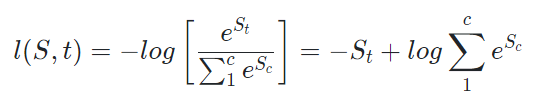


l : loss function

S : model의 output

t : target Class의 number

S_t : 정답 Class의 예측 score 값

c : Class 수

target의 정수 인코딩 값이 target Class의 number 로 적용되어 계산된다. 우선 decoder에서 출력된 logit값에 exp를 취한 뒤, 이를 모두 합하고 다시 log를 취한다. 계산된 값에서 정수 인코딩 값을 index로 취하는 logit값을 빼줌으로써 loss가 계산되고, 하나의 배치에서 계산되는 모든 loss를 합한 뒤 iterator length로 나눠줌으로써 계산된다.

#### 10. model eval 함수

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

train과 유사하지만 그레디언트 계산 및 역전파 하는 과정이 생략되었다.

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

model 학습시 소요되는 시간을 체크하는 함수다.

#### 11. trainer

In [112]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 22s
	Train Loss: 5.026 | Train PPL: 152.339
	 Val. Loss: 4.794 |  Val. PPL: 120.748
Epoch: 02 | Time: 0m 22s
	Train Loss: 4.094 | Train PPL:  59.960
	 Val. Loss: 4.295 |  Val. PPL:  73.298
Epoch: 03 | Time: 0m 22s
	Train Loss: 3.422 | Train PPL:  30.619
	 Val. Loss: 3.733 |  Val. PPL:  41.785
Epoch: 04 | Time: 0m 22s
	Train Loss: 2.885 | Train PPL:  17.910
	 Val. Loss: 3.449 |  Val. PPL:  31.473
Epoch: 05 | Time: 0m 22s
	Train Loss: 2.508 | Train PPL:  12.276
	 Val. Loss: 3.247 |  Val. PPL:  25.726
Epoch: 06 | Time: 0m 22s
	Train Loss: 2.186 | Train PPL:   8.904
	 Val. Loss: 3.247 |  Val. PPL:  25.711
Epoch: 07 | Time: 0m 22s
	Train Loss: 1.963 | Train PPL:   7.124
	 Val. Loss: 3.177 |  Val. PPL:  23.981
Epoch: 08 | Time: 0m 22s
	Train Loss: 1.757 | Train PPL:   5.793
	 Val. Loss: 3.223 |  Val. PPL:  25.102
Epoch: 09 | Time: 0m 22s
	Train Loss: 1.594 | Train PPL:   4.924
	 Val. Loss: 3.308 |  Val. PPL:  27.334
Epoch: 10 | Time: 0m 22s
	Train Loss: 1.467 | Train PPL

epoch 수와 그레디언트 클리핑 정도를 선언한다. 그레디언트 클리핑의 경우, 그레디언트의 크기를 조절해서 기울기 폭발이나 소실을 방지하는 방법이다.

epoch 마다 train, evaluate를 수행하고 loss를 계산 한뒤, 결과를 계속 업데이트 하여 모델의 학습 결과를 출력한다.

#### 12. test set 출력 결과 확인

In [87]:
model.load_state_dict(torch.load('tut3-model.pt'))
model.to(device)

def inference(model, iterator):
    
    model.eval()
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        output = model(src, trg, 0)
        #print(output.shape) #seq_length x batch size x vocab_size
        
        output = output.argmax(2) #seq_length x batch size
        output = output.permute(1, 0)
        
        #print(output.shape)
        
        predict = []
        for i, text in enumerate(output):
            
            tmp = ""
            for j in text[1:]:
                if j == TRG.vocab.stoi['<eos>']:
                    break
                
                text = TRG.vocab.itos[j]
                tmp = tmp + text + " "
            predict.append(tmp)
            
            
        trg = trg.permute(1, 0)
        real = []
        for i, text in enumerate(trg):
            
            tmp = ""
            for j in text[1:]:
                if j == TRG.vocab.stoi['<eos>']:
                    break
                
                text = TRG.vocab.itos[j]
                tmp = tmp + text + " "
            real.append(tmp)
        
    
        for i, j in zip(real, predict):
            print('real :', i)
            print('predict :', j)

        
inference(model, test_iterator)

real : two medium sized dogs run across the snow . 
predict : two brindle - dogs dogs running across the snow . 
real : four people are playing soccer on a beach . 
predict : four people are playing on on a beach on a beach . 
real : a boy riding a skateboard on a skateboarding ramp 
predict : a boy is skating on a ramp ramp . 
real : a dog is jumping through a <unk> obstacle . 
predict : a dog jumping through a hurdle . 
real : the two kids are playing at the playground . 
predict : the two children are playing on the playground . 
real : girl wearing radio t - shirt has open mouth 
predict : a girl in a <unk> costume with open open open open . 
real : a brown dog runs down the sandy beach . 
predict : a brown dog running across the shore . 
real : an asian factory worker posing for the camera . 
predict : an asian asian man poses for the camera . 
real : a boy in shorts doing a skateboard trick . 
predict : a boy in shorts is a a trick . 
real : a chinese man sitting down waiting for

real : small orchestra playing with open violin case in front 
predict : a orchestra playing playing with a guitar on the floor . 
real : two men sit talking near a stone building . 
predict : two men sit and and next to a building near a building . 
real : a young man skateboards off a pink railing . 
predict : a young man sliding down a pink railing over a pink railing . 
real : a girl at the shore of a beach with a mountain in the distance . 
predict : a girl on a shore with a mountain in the background . 
real : a man in a black leather coat is standing in front of a sign . 
predict : a man in a black leather jacket stands in front of a sign . 
real : a man trimming a palm tree inside a patio - type cafe ' . 
predict : a man is cutting a a sparkler in a palm tree . 
real : a man with work clothes on standing on the back of a truck . 
predict : a man in overalls is standing on the floor of his truck . 
real : four females of asian descent are wearing golden dresses while performing 

real : a woman with a push - to - talk cellphone and headset waiting at a crosswalk . 
predict : a woman with a panda hat and a waits waiting for a crosswalk . 
real : the soccer player wearing the gold jersey is blocking the ball from the opposing team player . 
predict : the soccer player in the gold uniform challenging the ball in the opposing team . 
real : a man dressed in black leather and a cowboy hat is walking around a renaissance festival . 
predict : a man in a black leather outfit and a cowboy hat is on a a . . 
real : a little girl with blond - hair is playing and splashing in a mud puddle . 
predict : a young girl with blond - hair is playing and and a sprinkler in a sprinkler . 
real : a man riding a running horse with some other men doing the same behind him . 
predict : a man on a rise with three men on horses behind horses . 
real : a baby girl eats a cookie while seated in a highchair and wearing a bib . 
predict : a baby sitting in a spoon in a a . 
real : a little 

real : a man in a black jacket and checkered hat wearing black and white striped pants plays an electric guitar on a stage with a singer and another guitar player in the background . 
predict : a man in a plaid jacket and a black jacket and black shorts and black shorts , and a black guitar and a guitar guitar on a guitar . 
real : a man wearing a gray shirt , blue jeans and a neon green safety vest is standing on a railroad track with a white truck and a white building in the background . 
predict : a man with a gray shirt , blue jeans and a a white truck , and a white truck white building with a white building . 
real : a boy in a red uniform is attempting to avoid getting out at home plate , while the catcher in the blue uniform is attempting to catch him . 
predict : a boy in a red jersey tries to catch a base while the baseman tries to catch the blue blue blue tries to catch him . 
real : two girls , one older and in black and one younger and in white , are performing the same bal